In [2]:
using Flux, ParameterSchedulers, Optimisers, Statistics, CUDA 
using Base.Iterators: repeated, partition
using Printf, BSON, JLD2, LinearAlgebra
using ImageCore, Images
using MLDatasets: convert2image, CIFAR10
using Plots              
using StatsBase

In [3]:
ENV["DATADEPS_ALWAYS_ACCEPT"] = "true"

"true"

In [4]:
train_set = CIFAR10(:train)

dataset CIFAR10:
  metadata  =>    Dict{String, Any} with 2 entries
  split     =>    :train
  features  =>    32×32×3×50000 Array{Float32, 4}
  targets   =>    50000-element Vector{Int64}

In [5]:
feats = Float32.(train_set.features)
channel_means = [ mean(vec(feats[:,:,c,:])) for c in 1:3 ]
channel_stds  = [ std( vec(feats[:,:,c,:]) ) for c in 1:3 ]
@info "Computed channel means: $channel_means"
@info "Computed channel stds:   $channel_stds"

[ Info: Computed channel means: Float32[0.49139968, 0.48215845, 0.44653094]
[ Info: Computed channel stds:   Float32[0.24703223, 0.24348514, 0.26158786]


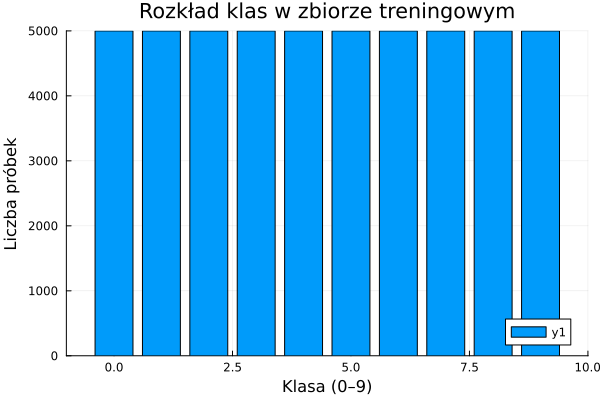

In [5]:
cls_counts = countmap(train_set.targets)
bar(
    0:9,
    [get(cls_counts, i, 0) for i in 0:9],
    xlabel="Klasa (0–9)",
    ylabel="Liczba próbek",
    title="Rozkład klas w zbiorze treningowym",
)

In [ ]:
using Images, ImageShow, Plots

classes = ["plane","car","bird","cat","deer","dog","frog","horse","ship","truck"]

# Funkcja do siatki 3×3
function show_samples_grid(X, Y; n=9)
    idx = rand(1:size(X,4), n)
    plt = plot(layout = (3,3), margin=2Plots.mm, xticks=false, yticks=false)
    for (i,j) in enumerate(idx)
        raw = X[:,:,:,j] |> cpu
        chw = permutedims(raw, (3,2,1))
        img = collect(colorview(RGB, chw))
        lab = isa(Y, AbstractMatrix) ? argmax(Y[:,j]) - 1 : Y[j]
        title = classes[lab+1]
        plot!(plt[i], img, seriestype = :heatmap,
              aspect_ratio=1, axis=false, title=title)
    end
    display(plt)
end


show_samples_grid (generic function with 1 method)

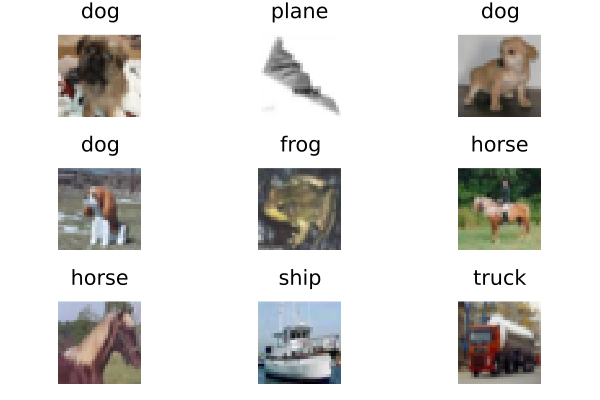

In [7]:
show_samples_grid(feats, train_set.targets; n=9)

In [7]:
use_cuda = true

true

In [8]:
if use_cuda && CUDA.functional()
    device = gpu
    @info "Training on GPU"
else
    device = cpu
    @info "Training on CPU"
end

[ Info: Training on GPU


In [9]:
epochs = 50;
batch_size = 64;

In [10]:
function make_minibatch(X, Y, idxs)
    X_batch = Array{Float32}(undef, 32, 32, 3, length(idxs))
    for (i, idx) in enumerate(idxs)
        X_batch[:,:,:,i] = X[:,:,:,idx]
    end
    Y_batch = Flux.onehotbatch(Y[idxs], 0:9)
    return X_batch, Y_batch
end

make_minibatch (generic function with 1 method)

In [11]:
mb_idxs = partition(1:size(train_set.features, 4), batch_size)
train_set = [make_minibatch(train_set.features, train_set.targets, i)  |> device for i in mb_idxs]

782-element Vector{Tuple{CuArray{Float32, 4, CUDA.DeviceMemory}, OneHotArrays.OneHotMatrix{UInt32, CuArray{UInt32, 1, CUDA.DeviceMemory}}}}:
 ([0.23137255 0.0627451 … 0.7058824 0.69411767; 0.16862746 0.0 … 0.6784314 0.65882355; … ; 0.59607846 0.46666667 … 0.38039216 0.5921569; 0.5803922 0.47843137 … 0.3254902 0.48235294;;; 0.24313726 0.078431375 … 0.54509807 0.5647059; 0.18039216 0.0 … 0.48235294 0.5058824; … ; 0.49019608 0.3254902 … 0.24313726 0.4627451; 0.4862745 0.34117648 … 0.20784314 0.36078432;;; 0.24705882 0.078431375 … 0.3764706 0.45490196; 0.1764706 0.0 … 0.16470589 0.36862746; … ; 0.4 0.19607843 … 0.13333334 0.32941177; 0.40392157 0.22352941 … 0.13333334 0.28235295;;;; 0.6039216 0.54901963 … 0.64705884 0.6392157; 0.49411765 0.5686275 … 0.6117647 0.61960787; … ; 0.34117648 0.3019608 … 0.48235294 0.56078434; 0.30980393 0.2784314 … 0.5137255 0.56078434;;; 0.69411767 0.627451 … 0.6039216 0.5803922; 0.5372549 0.6 … 0.59607846 0.5803922; … ; 0.3529412 0.3137255 … 0.44705883 0.52549

In [ ]:
# mb_idxs = partition(1:size(train_set.features, 4), batch_size)
# train_set = [make_minibatch(train_set.features, train_set.targets, i) for i in mb_idxs] |> device

782-element Vector{Tuple{Array{Float32, 4}, OneHotArrays.OneHotMatrix{UInt32, Vector{UInt32}}}}:
 ([0.23137255 0.0627451 … 0.7058824 0.69411767; 0.16862746 0.0 … 0.6784314 0.65882355; … ; 0.59607846 0.46666667 … 0.38039216 0.5921569; 0.5803922 0.47843137 … 0.3254902 0.48235294;;; 0.24313726 0.078431375 … 0.54509807 0.5647059; 0.18039216 0.0 … 0.48235294 0.5058824; … ; 0.49019608 0.3254902 … 0.24313726 0.4627451; 0.4862745 0.34117648 … 0.20784314 0.36078432;;; 0.24705882 0.078431375 … 0.3764706 0.45490196; 0.1764706 0.0 … 0.16470589 0.36862746; … ; 0.4 0.19607843 … 0.13333334 0.32941177; 0.40392157 0.22352941 … 0.13333334 0.28235295;;;; 0.6039216 0.54901963 … 0.64705884 0.6392157; 0.49411765 0.5686275 … 0.6117647 0.61960787; … ; 0.34117648 0.3019608 … 0.48235294 0.56078434; 0.30980393 0.2784314 … 0.5137255 0.56078434;;; 0.69411767 0.627451 … 0.6039216 0.5803922; 0.5372549 0.6 … 0.59607846 0.5803922; … ; 0.3529412 0.3137255 … 0.44705883 0.5254902; 0.31764707 0.28627452 … 0.4745098 0.5215

In [12]:
test_set = CIFAR10(:test)
test_set = make_minibatch(test_set.features, test_set.targets, 1:size(test_set.features)[4]) |> device

(Float32[0.61960787 0.59607846 … 0.23921569 0.21176471; 0.62352943 0.5921569 … 0.19215687 0.21960784; … ; 0.49411765 0.49019608 … 0.11372549 0.13333334; 0.45490196 0.46666667 … 0.078431375 0.08235294;;; 0.4392157 0.4392157 … 0.45490196 0.41960785; 0.43529412 0.43137255 … 0.4 0.4117647; … ; 0.35686275 0.35686275 … 0.32156864 0.32941177; 0.33333334 0.34509805 … 0.2509804 0.2627451;;; 0.19215687 0.2 … 0.65882355 0.627451; 0.18431373 0.15686275 … 0.5803922 0.58431375; … ; 0.14117648 0.1254902 … 0.49411765 0.5058824; 0.12941177 0.13333334 … 0.41960785 0.43137255;;;; 0.92156863 0.93333334 … 0.32156864 0.33333334; 0.90588236 0.92156863 … 0.18039216 0.24313726; … ; 0.9137255 0.9254902 … 0.7254902 0.7058824; 0.9098039 0.92156863 … 0.73333335 0.7294118;;; 0.92156863 0.93333334 … 0.3764706 0.39607844; 0.90588236 0.92156863 … 0.22352941 0.29411766; … ; 0.9137255 0.9254902 … 0.78431374 0.7647059; 0.9098039 0.92156863 … 0.7921569 0.78431374;;; 0.92156863 0.93333334 … 0.32156864 0.3254902; 0.90588236

In [ ]:
# test_set   = CIFAR10(:test)
# test_feats  = Float32.(test_set.features)
# test_labels = test_set.targets

# test_idxs = partition(1:size(test_feats,4), batch_size)

# test_set = [ make_minibatch(test_feats, test_labels, idxs) |> device for idxs in test_idxs ]


157-element Vector{Tuple{Array{Float32, 4}, OneHotArrays.OneHotMatrix{UInt32, Vector{UInt32}}}}:
 ([0.61960787 0.59607846 … 0.23921569 0.21176471; 0.62352943 0.5921569 … 0.19215687 0.21960784; … ; 0.49411765 0.49019608 … 0.11372549 0.13333334; 0.45490196 0.46666667 … 0.078431375 0.08235294;;; 0.4392157 0.4392157 … 0.45490196 0.41960785; 0.43529412 0.43137255 … 0.4 0.4117647; … ; 0.35686275 0.35686275 … 0.32156864 0.32941177; 0.33333334 0.34509805 … 0.2509804 0.2627451;;; 0.19215687 0.2 … 0.65882355 0.627451; 0.18431373 0.15686275 … 0.5803922 0.58431375; … ; 0.14117648 0.1254902 … 0.49411765 0.5058824; 0.12941177 0.13333334 … 0.41960785 0.43137255;;;; 0.92156863 0.93333334 … 0.32156864 0.33333334; 0.90588236 0.92156863 … 0.18039216 0.24313726; … ; 0.9137255 0.9254902 … 0.7254902 0.7058824; 0.9098039 0.92156863 … 0.73333335 0.7294118;;; 0.92156863 0.93333334 … 0.3764706 0.39607844; 0.90588236 0.92156863 … 0.22352941 0.29411766; … ; 0.9137255 0.9254902 … 0.78431374 0.7647059; 0.9098039 0.

In [46]:
model_small_convnet = Chain(
  # — blok 1: 32×32 → 16×16, kanały 3 → 16 —
  Conv((3,3), 3=>16, pad=1), BatchNorm(16), relu,
  MaxPool((2,2)),                           # 16×16

  # — blok 2: 16×16 → 8×8, kanały 16 → 32 —
  Conv((3,3), 16=>32, pad=1), BatchNorm(32), relu,
  MaxPool((2,2)),                           # 8×8

  # — blok 3: 8×8 → 4×4, kanały 32 → 64 —
  Conv((3,3), 32=>64, pad=1), BatchNorm(64), relu,
  MaxPool((2,2)),                           # 4×4

  # — flatten + head FC —
  flatten,                                  # 64*4*4 = 1024
  Dense(1024, 128), relu, Dropout(0.5),
  Dense(128,   10),
  softmax
) |> device

Chain(
  Conv((3, 3), 3 => 16, pad=1),         # 448 parameters
  BatchNorm(16),                        # 32 parameters, plus 32
  NNlib.relu,
  MaxPool((2, 2)),
  Conv((3, 3), 16 => 32, pad=1),        # 4_640 parameters
  BatchNorm(32),                        # 64 parameters, plus 64
  NNlib.relu,
  MaxPool((2, 2)),
  Conv((3, 3), 32 => 64, pad=1),        # 18_496 parameters
  BatchNorm(64),                        # 128 parameters, plus 128
  NNlib.relu,
  MaxPool((2, 2)),
  Flux.flatten,
  Dense(1024 => 128),                   # 131_200 parameters
  NNlib.relu,
  Dropout(0.5),
  Dense(128 => 10),                     # 1_290 parameters
  NNlib.softmax,
)         # Total: 16 trainable arrays, 156_298 parameters,
          # plus 6 non-trainable, 224 parameters, summarysize 3.922 KiB.

In [47]:
model_small_convnet(train_set[1][1])

10×64 CuArray{Float32, 2, CUDA.DeviceMemory}:
 0.116168   0.113968   0.123224   …  0.115629   0.114274   0.114452
 0.0953927  0.0872937  0.0849698     0.0955361  0.0914101  0.0950448
 0.102721   0.111247   0.11727       0.107675   0.109669   0.113373
 0.0725128  0.0684625  0.065835      0.0731382  0.0753755  0.0762563
 0.0969865  0.0938219  0.0790575     0.0965199  0.0964008  0.0892548
 0.098321   0.10099    0.112722   …  0.0983246  0.0989269  0.104917
 0.101125   0.100405   0.10298       0.104338   0.10377    0.0984471
 0.109525   0.110397   0.11638       0.106981   0.111109   0.106747
 0.100339   0.107982   0.0973858     0.0975266  0.096439   0.1007
 0.106909   0.105434   0.100176      0.104332   0.102626   0.100807

In [13]:
function loss(model, x, y, device = device)
    x = x |>cpu
    x_aug = x .+ 0.1f0*randn(eltype(x), size(x)) |> device
    y_hat = model(x_aug)
    return Flux.crossentropy(y_hat, y) 
end

loss (generic function with 2 methods)

In [48]:
loss(model_small_convnet, test_set[1],test_set[2])

2.3125815f0

In [ ]:
accuracy(model,x, y) = mean(Flux.onecold(model(x)) .== Flux.onecold(y))

accuracy (generic function with 1 method)

In [49]:
accuracy(model_small_convnet,test_set[1],test_set[2])

0.1011

In [50]:
opt = Flux.Adam(0.001)
opt_state = Flux.setup(opt, model_small_convnet);
lr_schedule = ParameterSchedulers.Stateful(Exp(start = opt.eta/10, decay = 0.1))

ParameterSchedulers.Stateful{Exp{Float64}, Int64, ParameterSchedulers.var"#15#17"}(Exp{Float64}(0.0001, 0.1), 1, ParameterSchedulers.var"#15#17"())

In [51]:
@info("Beginning training loop...")
best_acc = 0.0
last_improvement = 0
for epoch = 1:epochs
    global best_acc, last_improvement
    Flux.train!(loss, model_small_convnet, train_set, opt_state)
    acc = accuracy(model_small_convnet,test_set[1],test_set[2])
    @info(@sprintf("[%d]: Test accuracy: %.4f", epoch, acc))
    if acc >= best_acc
        @info(" -> New best accuracy! Saving model out to model_small_convnet.bson")
        ps = cpu(Flux.state(model_small_convnet))
        BSON.@save "model_small_convnet.bson" ps
        jldsave("model_small_convnet.jld2"; ps)
        best_acc = acc
        last_improvement = epoch
    end
    if acc >= 0.95
        @info(" -> Early-exiting: We reached our target accuracy of 95%")
        break
    end
    if epoch - last_improvement >= 5 
        η = ParameterSchedulers.next!(lr_schedule) 
        if η ≥ 1e-10
            Optimisers.adjust(opt_state, eta = η)
            @warn(" -> Haven't improved in a while, dropping learning rate to $(η)!")
            last_improvement = epoch
        end
    end
    if epoch - last_improvement >= 10
        @warn(" -> We're calling this converged.")
        break
    end
end

[ Info: Beginning training loop...
[ Info: [1]: Test accuracy: 0.4451
[ Info:  -> New best accuracy! Saving model out to model_small_convnet.bson
[ Info: [2]: Test accuracy: 0.4095
[ Info: [3]: Test accuracy: 0.5227
[ Info:  -> New best accuracy! Saving model out to model_small_convnet.bson
[ Info: [4]: Test accuracy: 0.5350
[ Info:  -> New best accuracy! Saving model out to model_small_convnet.bson
[ Info: [5]: Test accuracy: 0.5322
[ Info: [6]: Test accuracy: 0.5280
[ Info: [7]: Test accuracy: 0.5703
[ Info:  -> New best accuracy! Saving model out to model_small_convnet.bson
[ Info: [8]: Test accuracy: 0.5913
[ Info:  -> New best accuracy! Saving model out to model_small_convnet.bson
[ Info: [9]: Test accuracy: 0.5949
[ Info:  -> New best accuracy! Saving model out to model_small_convnet.bson
[ Info: [10]: Test accuracy: 0.5646
[ Info: [11]: Test accuracy: 0.6032
[ Info:  -> New best accuracy! Saving model out to model_small_convnet.bson
[ Info: [12]: Test accuracy: 0.6159
[ Info:  -

In [52]:
model_small_convnet = Chain(
  # — blok 1: 32×32 → 16×16, kanały 3 → 16 —
  Conv((3,3), 3=>16, pad=1), BatchNorm(16), relu,
  MaxPool((2,2)),                           # 16×16

  # — blok 2: 16×16 → 8×8, kanały 16 → 32 —
  Conv((3,3), 16=>32, pad=1), BatchNorm(32), relu,
  MaxPool((2,2)),                           # 8×8

  # — blok 3: 8×8 → 4×4, kanały 32 → 64 —
  Conv((3,3), 32=>64, pad=1), BatchNorm(64), relu,
  MaxPool((2,2)),                           # 4×4

  # — flatten + head FC —
  flatten,                                  # 64*4*4 = 1024
  Dense(1024, 128), relu, Dropout(0.5),
  Dense(128,   10),
  softmax
) |> device

BSON.@load "model_small_convnet.bson" ps

Flux.loadmodel!(model_small_convnet, device(ps))

Chain(
  Conv((3, 3), 3 => 16, pad=1),         # 448 parameters
  BatchNorm(16),                        # 32 parameters, plus 32
  NNlib.relu,
  MaxPool((2, 2)),
  Conv((3, 3), 16 => 32, pad=1),        # 4_640 parameters
  BatchNorm(32),                        # 64 parameters, plus 64
  NNlib.relu,
  MaxPool((2, 2)),
  Conv((3, 3), 32 => 64, pad=1),        # 18_496 parameters
  BatchNorm(64),                        # 128 parameters, plus 128
  NNlib.relu,
  MaxPool((2, 2)),
  Flux.flatten,
  Dense(1024 => 128),                   # 131_200 parameters
  NNlib.relu,
  Dropout(0.5),
  Dense(128 => 10),                     # 1_290 parameters
  NNlib.softmax,
)         # Total: 16 trainable arrays, 156_298 parameters,
          # plus 6 non-trainable, 224 parameters, summarysize 3.922 KiB.

In [53]:
accuracy(model_small_convnet,test_set[1],test_set[2])

0.7007

In [ ]:
X_test, Y_test = test_set   

# 1) Zrób predykcje i prawdziwe etykiety jako wektory 0–9
preds = Flux.onecold(model_small_convnet(X_test), 0:9)
trues = Flux.onecold(Y_test,      0:9)

# 2) Zainicjuj liczniki
class_correct = zeros(Int, 10)
class_total   = zeros(Int, 10)

# 3) Pętla po wszystkich próbkach
for (p, t) in zip(preds, trues)
    class_total[t+1]   += 1        
    class_correct[t+1] += (p == t)
end

# 4) Oblicz accuracy
class_accuracy = class_correct ./ class_total
for i in 1:10
    @printf("%-6s: %5.2f%%  (%4d/%4d)\n",
        classes[i], 100*class_accuracy[i],
        class_correct[i], class_total[i])
end


┌ Warning: Performing scalar indexing on task Task (runnable, started) @0x00000189e7e6ee90.
│ Invocation of getindex resulted in scalar indexing of a GPU array.
│ This is typically caused by calling an iterating implementation of a method.
│ Such implementations *do not* execute on the GPU, but very slowly on the CPU,
│ and therefore should be avoided.
│ 
│ If you want to allow scalar iteration, use `allowscalar` or `@allowscalar`
│ to enable scalar iteration globally or for the operations in question.
└ @ GPUArraysCore C:\Users\skocz\.julia\packages\GPUArraysCore\aNaXo\src\GPUArraysCore.jl:145


plane : 77.60%  ( 776/1000)
car   : 84.20%  ( 842/1000)
bird  : 64.50%  ( 645/1000)
cat   : 60.20%  ( 602/1000)
deer  : 51.40%  ( 514/1000)
dog   : 71.20%  ( 712/1000)
frog  : 52.80%  ( 528/1000)
horse : 77.10%  ( 771/1000)
ship  : 86.00%  ( 860/1000)
truck : 75.70%  ( 757/1000)


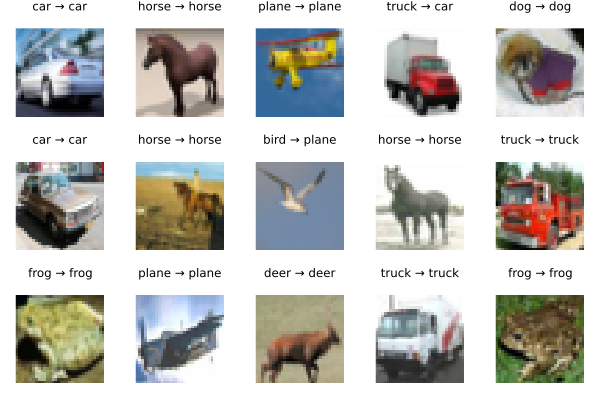

In [55]:
using Images, ImageShow, Plots

preds = Flux.onecold(model_small_convnet(X_test), 0:9)
trues = Flux.onecold(Y_test,      0:9)

function show_predictions(X, trues, preds; n=10)
    idxs = rand(1:size(X,4), n)
    cols = min(n,5); rows = ceil(Int,n/cols)
    plt = plot(layout=(rows,cols), margin=2Plots.mm, xticks=false, yticks=false)
    for (i,j) in enumerate(idxs)
        raw = X[:,:,:,j] |> cpu
        chw = permutedims(raw, (3,2,1))
        img = collect(colorview(RGB, chw))
        title = "$(classes[trues[j]+1]) → $(classes[preds[j]+1])"
        plot!(plt[i], img, seriestype=:heatmap,
              aspect_ratio=1, axis=false, title=title, titlefontsize=8)
    end
    display(plt)
end

show_predictions(X_test, trues, preds; n=15)


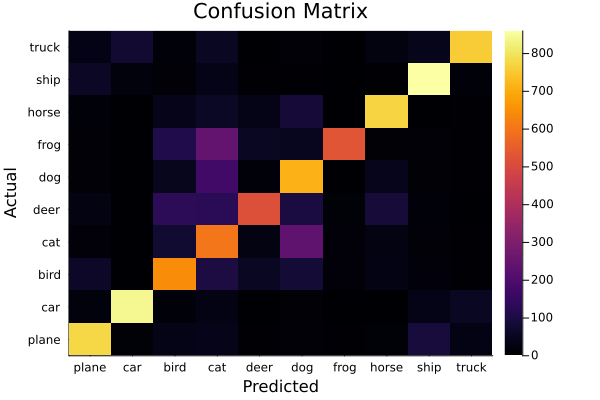

In [56]:
using StatsBase, Plots

cm = zeros(Int, 10, 10)
for (t,p) in zip(trues, preds)
    cm[t+1, p+1] += 1
end

heatmap(
  cm,
  xticks=(1:10, classes),
  yticks=(1:10, classes),
  xlabel="Predicted",
  ylabel="Actual",
  title="Confusion Matrix",
  right_margin = 10Plots.mm,
)


In [30]:
using Flux
using Flux: Conv, BatchNorm, MaxPool, flatten, Dense, Dropout, relu, softmax, Chain

# -- definicja jednego Res-bloku o stałej liczbie kanałów --
struct ResBlock
  f::Chain
end

function ResBlock(channels::Integer)
  return ResBlock(Chain(
    Conv((3,3), channels=>channels, pad=1),
    BatchNorm(channels), relu,
    Conv((3,3), channels=>channels, pad=1),
    BatchNorm(channels)
  ))
end

# aplikacja bloku: F(x)+x, potem ReLU
(m::ResBlock)(x) = relu(m.f(x) .+ x)


# -- model --
model_resNet = Chain(
  # Block 1: 3→32
  Conv((3,3), 3=>32, pad=1), BatchNorm(32), relu,
  ResBlock(32),
  MaxPool((2,2)),      # 32×32 → 16×16

  # Block 2: 32→64
  Conv((3,3), 32=>64, pad=1), BatchNorm(64), relu,
  ResBlock(64),
  MaxPool((2,2)),      # 16×16 → 8×8

  # Flatten i head
  flatten,             # 64*8*8 = 4096
  Dense(4096, 128),    BatchNorm(128), relu, Dropout(0.5),
  Dense(128, 10),
  softmax
) |> device


Chain(
  Conv((3, 3), 3 => 32, pad=1),         # 896 parameters
  BatchNorm(32),                        # 64 parameters, plus 64
  NNlib.relu,
  ResBlock(
    Chain(
      Conv((3, 3), 32 => 32, pad=1),    # 9_248 parameters
      BatchNorm(32),                    # 64 parameters, plus 64
      NNlib.relu,
      Conv((3, 3), 32 => 32, pad=1),    # 9_248 parameters
      BatchNorm(32),                    # 64 parameters, plus 64
    ),
  ),
  MaxPool((2, 2)),
  Conv((3, 3), 32 => 64, pad=1),        # 18_496 parameters
  BatchNorm(64),                        # 128 parameters, plus 128
  NNlib.relu,
  ResBlock(
    Chain(
      Conv((3, 3), 64 => 64, pad=1),    # 36_928 parameters
      BatchNorm(64),                    # 128 parameters, plus 128
      NNlib.relu,
      Conv((3, 3), 64 => 64, pad=1),    # 36_928 parameters
      BatchNorm(64),                    # 128 parameters, plus 128
    ),
  ),
  MaxPool((2, 2)),
  Flux.flatten,
  Dense(4096 => 128),                   # 524_416 para

In [31]:
model_resNet(train_set[1][1])

10×64 CuArray{Float32, 2, CUDA.DeviceMemory}:
 0.109314   0.129865   0.145935   …  0.125635   0.122628   0.122042
 0.0900637  0.0809569  0.0774794     0.0758107  0.0803738  0.09279
 0.0931379  0.0778614  0.0807259     0.0813434  0.0860804  0.0907368
 0.115918   0.131022   0.11976       0.117198   0.11236    0.111028
 0.0822906  0.0799071  0.105968      0.0918979  0.0903146  0.0921533
 0.122271   0.126079   0.120993   …  0.131113   0.124007   0.122793
 0.0871029  0.0822763  0.0772774     0.0793578  0.0822831  0.0822781
 0.102035   0.099139   0.0889659     0.103126   0.0980054  0.0906628
 0.103407   0.106318   0.101593      0.109514   0.1116     0.0996453
 0.0944611  0.0865744  0.0813032     0.0850038  0.0923476  0.0958697

In [32]:
opt = Flux.Adam(0.001)
opt_state = Flux.setup(opt, model_resNet);
lr_schedule = ParameterSchedulers.Stateful(Exp(start = opt.eta/10, decay = 0.1))

ParameterSchedulers.Stateful{Exp{Float64}, Int64, ParameterSchedulers.var"#15#17"}(Exp{Float64}(0.0001, 0.1), 1, ParameterSchedulers.var"#15#17"())

In [16]:
function accuracy_batched(model, X, Y; batchsize=64)
  total, correct = 0, 0
  N = size(X, 4)
  for i in 1:batchsize:N
    j = min(i+batchsize-1, N)
    xb = device(X[:,:,:, i:j])
    yb = device(Y[:,   i:j])
    ŷ = model(xb)
    p = Flux.onecold(ŷ, 0:9)
    t = Flux.onecold(yb, 0:9)
    correct += sum(p .== t)
    total   += length(t)
  end
  return correct / total
end

# acc = accuracy_batched(model, X_test, Y_test; batchsize=batch_size)
# @info("Test accuracy: $(round(acc*100, digits=2))%")

accuracy_batched (generic function with 1 method)

In [17]:
X_test, Y_test = test_set

(Float32[0.61960787 0.59607846 … 0.23921569 0.21176471; 0.62352943 0.5921569 … 0.19215687 0.21960784; … ; 0.49411765 0.49019608 … 0.11372549 0.13333334; 0.45490196 0.46666667 … 0.078431375 0.08235294;;; 0.4392157 0.4392157 … 0.45490196 0.41960785; 0.43529412 0.43137255 … 0.4 0.4117647; … ; 0.35686275 0.35686275 … 0.32156864 0.32941177; 0.33333334 0.34509805 … 0.2509804 0.2627451;;; 0.19215687 0.2 … 0.65882355 0.627451; 0.18431373 0.15686275 … 0.5803922 0.58431375; … ; 0.14117648 0.1254902 … 0.49411765 0.5058824; 0.12941177 0.13333334 … 0.41960785 0.43137255;;;; 0.92156863 0.93333334 … 0.32156864 0.33333334; 0.90588236 0.92156863 … 0.18039216 0.24313726; … ; 0.9137255 0.9254902 … 0.7254902 0.7058824; 0.9098039 0.92156863 … 0.73333335 0.7294118;;; 0.92156863 0.93333334 … 0.3764706 0.39607844; 0.90588236 0.92156863 … 0.22352941 0.29411766; … ; 0.9137255 0.9254902 … 0.78431374 0.7647059; 0.9098039 0.92156863 … 0.7921569 0.78431374;;; 0.92156863 0.93333334 … 0.32156864 0.3254902; 0.90588236

In [35]:
@info("Beginning training loop...")
best_acc = 0.0
last_improvement = 0
for epoch = 1:epochs
    global best_acc, last_improvement
    Flux.train!(loss, model_resNet, train_set, opt_state)
    acc = accuracy_batched(model_resNet, X_test, Y_test; batchsize=batch_size)
    @info(@sprintf("[%d]: Test accuracy: %.4f", epoch, acc))
    if acc >= best_acc
        @info(" -> New best accuracy! Saving model out to model_resNet.bson")
        ps = cpu(Flux.state(model_resNet))
        BSON.@save "model_resNet.bson" ps
        jldsave("model_resNet.jld2"; ps)
        best_acc = acc
        last_improvement = epoch
    end
    if acc >= 0.95
        @info(" -> Early-exiting: We reached our target accuracy of 95%")
        break
    end
    if epoch - last_improvement >= 5 
        η = ParameterSchedulers.next!(lr_schedule) 
        if η ≥ 1e-10
            Optimisers.adjust(opt_state, eta = η)
            @warn(" -> Haven't improved in a while, dropping learning rate to $(η)!")
            last_improvement = epoch
        end
    end
    if epoch - last_improvement >= 10
        @warn(" -> We're calling this converged.")
        break
    end
end

[ Info: Beginning training loop...
[ Info: [1]: Test accuracy: 0.5936
[ Info:  -> New best accuracy! Saving model out to model_resNet.bson
[ Info: [2]: Test accuracy: 0.5975
[ Info:  -> New best accuracy! Saving model out to model_resNet.bson
[ Info: [3]: Test accuracy: 0.6661
[ Info:  -> New best accuracy! Saving model out to model_resNet.bson
[ Info: [4]: Test accuracy: 0.6669
[ Info:  -> New best accuracy! Saving model out to model_resNet.bson
[ Info: [5]: Test accuracy: 0.6797
[ Info:  -> New best accuracy! Saving model out to model_resNet.bson
[ Info: [6]: Test accuracy: 0.6802
[ Info:  -> New best accuracy! Saving model out to model_resNet.bson
[ Info: [7]: Test accuracy: 0.6992
[ Info:  -> New best accuracy! Saving model out to model_resNet.bson
[ Info: [8]: Test accuracy: 0.7062
[ Info:  -> New best accuracy! Saving model out to model_resNet.bson
[ Info: [9]: Test accuracy: 0.7120
[ Info:  -> New best accuracy! Saving model out to model_resNet.bson
[ Info: [10]: Test accuracy: 

In [36]:
model_resNet = Chain(
  # Block 1: 3→32
  Conv((3,3), 3=>32, pad=1), BatchNorm(32), relu,
  ResBlock(32),
  MaxPool((2,2)),      # 32×32 → 16×16

  # Block 2: 32→64
  Conv((3,3), 32=>64, pad=1), BatchNorm(64), relu,
  ResBlock(64),
  MaxPool((2,2)),      # 16×16 → 8×8

  # Flatten i head
  flatten,             # 64*8*8 = 4096
  Dense(4096, 128),    BatchNorm(128), relu, Dropout(0.5),
  Dense(128, 10),
  softmax
) |> device

BSON.@load "model_resNet.bson" ps

Flux.loadmodel!(model_resNet, device(ps))

Chain(
  Conv((3, 3), 3 => 32, pad=1),         # 896 parameters
  BatchNorm(32),                        # 64 parameters, plus 64
  NNlib.relu,
  ResBlock(
    Chain(
      Conv((3, 3), 32 => 32, pad=1),    # 9_248 parameters
      BatchNorm(32),                    # 64 parameters, plus 64
      NNlib.relu,
      Conv((3, 3), 32 => 32, pad=1),    # 9_248 parameters
      BatchNorm(32),                    # 64 parameters, plus 64
    ),
  ),
  MaxPool((2, 2)),
  Conv((3, 3), 32 => 64, pad=1),        # 18_496 parameters
  BatchNorm(64),                        # 128 parameters, plus 128
  NNlib.relu,
  ResBlock(
    Chain(
      Conv((3, 3), 64 => 64, pad=1),    # 36_928 parameters
      BatchNorm(64),                    # 128 parameters, plus 128
      NNlib.relu,
      Conv((3, 3), 64 => 64, pad=1),    # 36_928 parameters
      BatchNorm(64),                    # 128 parameters, plus 128
    ),
  ),
  MaxPool((2, 2)),
  Flux.flatten,
  Dense(4096 => 128),                   # 524_416 para

In [37]:
accuracy(model_resNet,test_set[1],test_set[2])

0.7584

In [18]:
using Flux
using Flux: Conv, BatchNorm, MaxPool, flatten, Dense, Dropout, relu, softmax, Chain

# VGG-like CNN dla wejścia 3×32×32
model_vgg = Chain(
  # --- blok 1: 3 → 64 ---
  Conv((3,3), 3=>64, pad=1), relu,
  Conv((3,3), 64=>64, pad=1), relu,
  MaxPool((2,2)),               # 32×32 → 16×16

  # --- blok 2: 64 → 128 ---
  Conv((3,3), 64=>128, pad=1), relu,
  Conv((3,3), 128=>128, pad=1), relu,
  MaxPool((2,2)),               # 16×16 → 8×8

  # --- blok 3: 128 → 256 ---
  Conv((3,3), 128=>256, pad=1), relu,
  Conv((3,3), 256=>256, pad=1), relu,
  MaxPool((2,2)),               # 8×8 → 4×4

  # spłaszczamy
  flatten,                      # 256×4×4 = 4096

  # --- klasyfikator ---
  Dense(4096, 512), relu, Dropout(0.5),
  Dense(512, 256), relu, Dropout(0.5),
  Dense(256, 10),
  softmax
) |> device


Chain(
  Conv((3, 3), 3 => 64, pad=1),         # 1_792 parameters
  NNlib.relu,
  Conv((3, 3), 64 => 64, pad=1),        # 36_928 parameters
  NNlib.relu,
  MaxPool((2, 2)),
  Conv((3, 3), 64 => 128, pad=1),       # 73_856 parameters
  NNlib.relu,
  Conv((3, 3), 128 => 128, pad=1),      # 147_584 parameters
  NNlib.relu,
  MaxPool((2, 2)),
  Conv((3, 3), 128 => 256, pad=1),      # 295_168 parameters
  NNlib.relu,
  Conv((3, 3), 256 => 256, pad=1),      # 590_080 parameters
  NNlib.relu,
  MaxPool((2, 2)),
  Flux.flatten,
  Dense(4096 => 512),                   # 2_097_664 parameters
  NNlib.relu,
  Dropout(0.5),
  Dense(512 => 256),                    # 131_328 parameters
  NNlib.relu,
  Dropout(0.5),
  Dense(256 => 10),                     # 2_570 parameters
  NNlib.softmax,
)                   # Total: 18 arrays, 3_376_970 parameters, 3.555 KiB.

In [19]:
model_vgg(train_set[1][1])

10×64 CuArray{Float32, 2, CUDA.DeviceMemory}:
 0.0980338  0.0967672  0.0962775  …  0.0965654  0.0969299  0.0971024
 0.100062   0.100724   0.101655      0.100982   0.100733   0.100971
 0.101931   0.102787   0.102602      0.102695   0.101801   0.101306
 0.102111   0.102523   0.10294       0.10333    0.102296   0.101838
 0.0970268  0.0955799  0.0947031     0.0955807  0.0955905  0.0969639
 0.100424   0.10094    0.101002   …  0.100534   0.101169   0.100871
 0.102      0.101553   0.102324      0.102484   0.102211   0.101221
 0.10198    0.103585   0.105332      0.102908   0.10314    0.103127
 0.0955057  0.0943014  0.0928554     0.0938896  0.0947435  0.0959925
 0.100926   0.101239   0.10031       0.101032   0.101386   0.100606

In [20]:
opt = Flux.Adam(0.001)
opt_state = Flux.setup(opt, model_vgg);
lr_schedule = ParameterSchedulers.Stateful(Exp(start = opt.eta/10, decay = 0.1))

ParameterSchedulers.Stateful{Exp{Float64}, Int64, ParameterSchedulers.var"#15#17"}(Exp{Float64}(0.0001, 0.1), 1, ParameterSchedulers.var"#15#17"())

In [21]:
@info("Beginning training loop...")
best_acc = 0.0
last_improvement = 0
for epoch = 1:epochs
    global best_acc, last_improvement
    Flux.train!(loss, model_vgg, train_set, opt_state)
    acc = accuracy_batched(model_vgg, X_test, Y_test; batchsize=batch_size)
    @info(@sprintf("[%d]: Test accuracy: %.4f", epoch, acc))
    if acc >= best_acc
        @info(" -> New best accuracy! Saving model out to model_vgg.bson")
        ps = cpu(Flux.state(model_vgg))
        BSON.@save "model_vgg.bson" ps
        jldsave("model_vgg.jld2"; ps)
        best_acc = acc
        last_improvement = epoch
    end
    if acc >= 0.95
        @info(" -> Early-exiting: We reached our target accuracy of 95%")
        break
    end
    if epoch - last_improvement >= 5 
        η = ParameterSchedulers.next!(lr_schedule) 
        if η ≥ 1e-10
            Optimisers.adjust(opt_state, eta = η)
            @warn(" -> Haven't improved in a while, dropping learning rate to $(η)!")
            last_improvement = epoch
        end
    end
    if epoch - last_improvement >= 10
        @warn(" -> We're calling this converged.")
        break
    end
end

[ Info: Beginning training loop...
[ Info: [1]: Test accuracy: 0.5253
[ Info:  -> New best accuracy! Saving model out to model_vgg.bson
[ Info: [2]: Test accuracy: 0.6008
[ Info:  -> New best accuracy! Saving model out to model_vgg.bson
[ Info: [3]: Test accuracy: 0.6458
[ Info:  -> New best accuracy! Saving model out to model_vgg.bson
[ Info: [4]: Test accuracy: 0.6748
[ Info:  -> New best accuracy! Saving model out to model_vgg.bson
[ Info: [5]: Test accuracy: 0.6897
[ Info:  -> New best accuracy! Saving model out to model_vgg.bson
[ Info: [6]: Test accuracy: 0.6985
[ Info:  -> New best accuracy! Saving model out to model_vgg.bson
[ Info: [7]: Test accuracy: 0.6870
[ Info: [8]: Test accuracy: 0.7100
[ Info:  -> New best accuracy! Saving model out to model_vgg.bson
[ Info: [9]: Test accuracy: 0.7004
[ Info: [10]: Test accuracy: 0.7126
[ Info:  -> New best accuracy! Saving model out to model_vgg.bson
[ Info: [11]: Test accuracy: 0.7067
[ Info: [12]: Test accuracy: 0.7270
[ Info:  -> Ne

In [22]:
model_vgg = Chain(
  # --- blok 1: 3 → 64 ---
  Conv((3,3), 3=>64, pad=1), relu,
  Conv((3,3), 64=>64, pad=1), relu,
  MaxPool((2,2)),               # 32×32 → 16×16

  # --- blok 2: 64 → 128 ---
  Conv((3,3), 64=>128, pad=1), relu,
  Conv((3,3), 128=>128, pad=1), relu,
  MaxPool((2,2)),               # 16×16 → 8×8

  # --- blok 3: 128 → 256 ---
  Conv((3,3), 128=>256, pad=1), relu,
  Conv((3,3), 256=>256, pad=1), relu,
  MaxPool((2,2)),               # 8×8 → 4×4

  # spłaszczamy
  flatten,                      # 256×4×4 = 4096

  # --- klasyfikator ---
  Dense(4096, 512), relu, Dropout(0.5),
  Dense(512, 256), relu, Dropout(0.5),
  Dense(256, 10),
  softmax
) |> device

BSON.@load "model_vgg.bson" ps

Flux.loadmodel!(model_vgg, device(ps))

Chain(
  Conv((3, 3), 3 => 64, pad=1),         # 1_792 parameters
  NNlib.relu,
  Conv((3, 3), 64 => 64, pad=1),        # 36_928 parameters
  NNlib.relu,
  MaxPool((2, 2)),
  Conv((3, 3), 64 => 128, pad=1),       # 73_856 parameters
  NNlib.relu,
  Conv((3, 3), 128 => 128, pad=1),      # 147_584 parameters
  NNlib.relu,
  MaxPool((2, 2)),
  Conv((3, 3), 128 => 256, pad=1),      # 295_168 parameters
  NNlib.relu,
  Conv((3, 3), 256 => 256, pad=1),      # 590_080 parameters
  NNlib.relu,
  MaxPool((2, 2)),
  Flux.flatten,
  Dense(4096 => 512),                   # 2_097_664 parameters
  NNlib.relu,
  Dropout(0.5),
  Dense(512 => 256),                    # 131_328 parameters
  NNlib.relu,
  Dropout(0.5),
  Dense(256 => 10),                     # 2_570 parameters
  NNlib.softmax,
)                   # Total: 18 arrays, 3_376_970 parameters, 3.555 KiB.

In [24]:
accuracy_batched(model_vgg, X_test, Y_test; batchsize=batch_size)

0.7457

In [36]:
using Flux
using Flux: Conv, relu, softmax, flatten
using NNlib: pad

model_allcnn = Chain(
  # -- blok 1 --
  Conv((3,3), 3=>96, pad=1), relu,
  Conv((3,3), 96=>96, pad=1), relu,
  Conv((3,3), 96=>96, stride=2, pad=1), relu,   # downsample 32→16

  # -- blok 2 --
  Conv((3,3), 96=>192, pad=1), relu,
  Conv((3,3), 192=>192, pad=1), relu,
  Conv((3,3), 192=>192, stride=2, pad=1), relu, # downsample 16→8

  # -- blok 3 (klasyfikator) --
  Conv((3,3), 192=>192, pad=1), relu,
  Conv((1,1), 192=>192, pad=0), relu,
  Conv((1,1), 192=>10,  pad=0),              # mapujemy do 10 kanałów

  # -- global average pooling + softmax --
  x -> mean(x, dims=(1,2)),  # (10×1×1×N)
  flatten,                   # → (10, N)
  softmax
) |> device


Chain(
  Conv((3, 3), 3 => 96, pad=1),         # 2_688 parameters
  NNlib.relu,
  Conv((3, 3), 96 => 96, pad=1),        # 83_040 parameters
  NNlib.relu,
  Conv((3, 3), 96 => 96, pad=1, stride=2),  # 83_040 parameters
  NNlib.relu,
  Conv((3, 3), 96 => 192, pad=1),       # 166_080 parameters
  NNlib.relu,
  Conv((3, 3), 192 => 192, pad=1),      # 331_968 parameters
  NNlib.relu,
  Conv((3, 3), 192 => 192, pad=1, stride=2),  # 331_968 parameters
  NNlib.relu,
  Conv((3, 3), 192 => 192, pad=1),      # 331_968 parameters
  NNlib.relu,
  Conv((1, 1), 192 => 192),             # 37_056 parameters
  NNlib.relu,
  Conv((1, 1), 192 => 10),              # 1_930 parameters
  var"#13#14"(),
  Flux.flatten,
  NNlib.softmax,
)                   # Total: 18 arrays, 1_369_738 parameters, 3.555 KiB.

In [37]:
X0, _ = train_set[1]
ŷ0 = model_allcnn(X0)
@show size(ŷ0)   # powinno być (10, batch_size)


size(ŷ0) = (10, 64)


(10, 64)

In [38]:
model_allcnn(train_set[1][1])

10×64 CuArray{Float32, 2, CUDA.DeviceMemory}:
 0.100258   0.100295   0.100287   …  0.100248   0.100206   0.100152
 0.100058   0.100046   0.100024      0.100031   0.100054   0.0999943
 0.100023   0.0999373  0.0999195     0.0999059  0.0998725  0.099941
 0.100178   0.100417   0.100349      0.10038    0.100435   0.100247
 0.0998196  0.0996839  0.0997383     0.0997006  0.099738   0.0998257
 0.0999292  0.0999435  0.0999545  …  0.0999671  0.0999965  0.0999671
 0.099812   0.0997549  0.0997743     0.0997914  0.0997816  0.0998501
 0.0997631  0.0997544  0.099768      0.0997759  0.099789   0.0998832
 0.0999517  0.0999545  0.099979      0.0999926  0.0999751  0.099991
 0.100207   0.100214   0.100205      0.100207   0.100153   0.100148

In [29]:
opt = Flux.Adam(0.001)
opt_state = Flux.setup(opt, model_allcnn);
lr_schedule = ParameterSchedulers.Stateful(Exp(start = opt.eta/10, decay = 0.1))

ParameterSchedulers.Stateful{Exp{Float64}, Int64, ParameterSchedulers.var"#15#17"}(Exp{Float64}(0.0001, 0.1), 1, ParameterSchedulers.var"#15#17"())

In [39]:
@info("Beginning training loop...")
best_acc = 0.0
last_improvement = 0
for epoch = 1:epochs
    global best_acc, last_improvement
    Flux.train!(loss, model_allcnn, train_set, opt_state)
    acc = accuracy_batched(model_allcnn, X_test, Y_test; batchsize=batch_size)
    @info(@sprintf("[%d]: Test accuracy: %.4f", epoch, acc))
    if acc >= best_acc
        @info(" -> New best accuracy! Saving model out to model_allcnn.bson")
        ps = cpu(Flux.state(model_allcnn))
        BSON.@save "model_allcnn.bson" ps
        jldsave("model_allcnn.jld2"; ps)
        best_acc = acc
        last_improvement = epoch
    end
    if acc >= 0.95
        @info(" -> Early-exiting: We reached our target accuracy of 95%")
        break
    end
    if epoch - last_improvement >= 5 
        η = ParameterSchedulers.next!(lr_schedule) 
        if η ≥ 1e-10
            Optimisers.adjust(opt_state, eta = η)
            @warn(" -> Haven't improved in a while, dropping learning rate to $(η)!")
            last_improvement = epoch
        end
    end
    if epoch - last_improvement >= 10
        @warn(" -> We're calling this converged.")
        break
    end
end

[ Info: Beginning training loop...
[ Info: [1]: Test accuracy: 0.3866
[ Info:  -> New best accuracy! Saving model out to model_allcnn.bson
[ Info: [2]: Test accuracy: 0.5270
[ Info:  -> New best accuracy! Saving model out to model_allcnn.bson
[ Info: [3]: Test accuracy: 0.5926
[ Info:  -> New best accuracy! Saving model out to model_allcnn.bson
[ Info: [4]: Test accuracy: 0.6142
[ Info:  -> New best accuracy! Saving model out to model_allcnn.bson
[ Info: [5]: Test accuracy: 0.6334
[ Info:  -> New best accuracy! Saving model out to model_allcnn.bson
[ Info: [6]: Test accuracy: 0.6672
[ Info:  -> New best accuracy! Saving model out to model_allcnn.bson
[ Info: [7]: Test accuracy: 0.6747
[ Info:  -> New best accuracy! Saving model out to model_allcnn.bson
[ Info: [8]: Test accuracy: 0.6768
[ Info:  -> New best accuracy! Saving model out to model_allcnn.bson
[ Info: [9]: Test accuracy: 0.6915
[ Info:  -> New best accuracy! Saving model out to model_allcnn.bson
[ Info: [10]: Test accuracy: 

In [44]:
model_allcnn = Chain(
  # -- blok 1 --
  Conv((3,3), 3=>96, pad=1), relu,
  Conv((3,3), 96=>96, pad=1), relu,
  Conv((3,3), 96=>96, stride=2, pad=1), relu,   # downsample 32→16

  # -- blok 2 --
  Conv((3,3), 96=>192, pad=1), relu,
  Conv((3,3), 192=>192, pad=1), relu,
  Conv((3,3), 192=>192, stride=2, pad=1), relu, # downsample 16→8

  # -- blok 3 (klasyfikator) --
  Conv((3,3), 192=>192, pad=1), relu,
  Conv((1,1), 192=>192, pad=0), relu,
  Conv((1,1), 192=>10,  pad=0),              # mapujemy do 10 kanałów

  # -- global average pooling + softmax --
  x -> mean(x, dims=(1,2)),  # (10×1×1×N)
  flatten,                   # → (10, N)
  softmax
) |> device

BSON.@load "model_allcnn.bson" ps

Flux.loadmodel!(model_allcnn, device(ps))

Chain(
  Conv((3, 3), 3 => 96, pad=1),         # 2_688 parameters
  NNlib.relu,
  Conv((3, 3), 96 => 96, pad=1),        # 83_040 parameters
  NNlib.relu,
  Conv((3, 3), 96 => 96, pad=1, stride=2),  # 83_040 parameters
  NNlib.relu,
  Conv((3, 3), 96 => 192, pad=1),       # 166_080 parameters
  NNlib.relu,
  Conv((3, 3), 192 => 192, pad=1),      # 331_968 parameters
  NNlib.relu,
  Conv((3, 3), 192 => 192, pad=1, stride=2),  # 331_968 parameters
  NNlib.relu,
  Conv((3, 3), 192 => 192, pad=1),      # 331_968 parameters
  NNlib.relu,
  Conv((1, 1), 192 => 192),             # 37_056 parameters
  NNlib.relu,
  Conv((1, 1), 192 => 10),              # 1_930 parameters
  var"#19#20"(),
  Flux.flatten,
  NNlib.softmax,
)                   # Total: 18 arrays, 1_369_738 parameters, 3.555 KiB.

In [45]:
accuracy_batched(model_allcnn, X_test, Y_test; batchsize=batch_size)

0.7273